In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import px4tools.ulog
import px4tools.version
import scipy.integrate

In [3]:
pd.__version__

'0.19.99'

In [4]:
px4tools.version.git_revision

'a7d187473ff1c9ef722c15da4a3f84919e73f682'

In [28]:
p_gyro = {
    'rate': 250,
    'noise_density': 0.0003394,
    'random_walk': 3.8785e-05,
    'bias_correlation_time': 1000.0,
    'turn_on_bias_sigma': 0.0087
}
p_accel = {
    'rate': 250,
    'noise_density': 0.004,
    'random_walk': 0.006,
    'bias_correlation_time': 300.0,
    'turn_on_bias_sigma': 0.196,
}
p_gyro, p_accel

({'bias_correlation_time': 1000.0,
  'noise_density': 0.0003394,
  'random_walk': 3.8785e-05,
  'rate': 250,
  'turn_on_bias_sigma': 0.0087},
 {'bias_correlation_time': 300.0,
  'noise_density': 0.004,
  'random_walk': 0.006,
  'rate': 250,
  'turn_on_bias_sigma': 0.196})

In [29]:
def simulate(p, verbose=False):
    from numpy.random import randn
    d = []
    dt = 1.0/p['rate']
    tf = 10000
    tau = p['bias_correlation_time'] 
    sigma_w = p['noise_density'] 
    sigma_w_d = sigma_w / sqrt(dt)
    sigma_bias = p['random_walk']
    sigma_bias_d = sigma_bias*sqrt(tau/2*(1 -np.exp(-2*dt/tau)))
    i = 0
    x = p['turn_on_bias_sigma'] * randn()
    for t in np.arange(0, tf, dt):
        phi = np.exp(-dt/tau)
        x = phi*x + sigma_bias_d * randn()
        y = x + sigma_w_d * randn()
        d.append({
            'timestamp': t*1e6,
            't_sensor_gyro_0__f_x': y
        })
        i += 1
        if i % int(1000/dt) == 0:
            if verbose:
                print(int(100*t/tf))
    df = pd.DataFrame(d)
    df.index = pd.TimedeltaIndex(df.timestamp/1e6, 's')
    return df

In [30]:
data_gyro = simulate(p_gyro)

{'sig_bi': 0.0001898943503022946,
 'sig_rrw': 4.7371358766793405e-05,
 'sig_rw': 0.00035621438918120505,
 'tau_0': 1.4912822583029897,
 'tau_1': 12.692974373944944,
 'tau_2': 40.280844107825374}

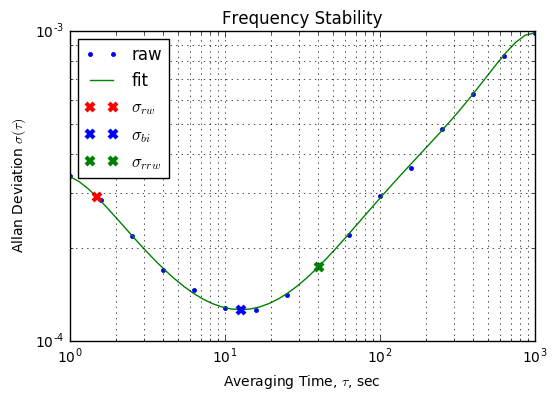

In [31]:
res = px4tools.ulog.plot_allan_std_dev(
    data_gyro.t_sensor_gyro_0__f_x.resample('1 s').agg('mean'), poly_order=8)
legend(loc='best')
res

1841.1319752236386

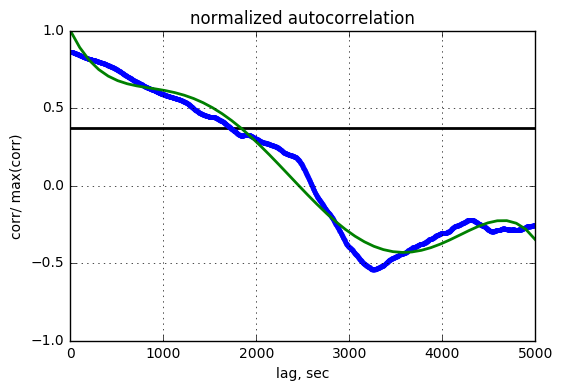

In [51]:
px4tools.ulog.plot_autocorrelation(data_gyro.t_sensor_gyro_0__f_x)

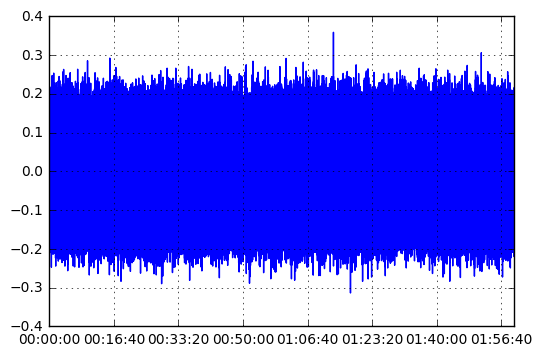

In [11]:
data.t_sensor_gyro_0__f_x[:'1 h'].plot()
plt.grid()